## A single layer neural network predicting MNIST hand-written digits

In [1]:
from simpledl.DLTrainer import DLTrainer
from simpledl.ONNXManager import ONNXManager
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Create our own trainer with its own load_data function
class MyDLTrainer(DLTrainer):
    def load_data(self, test_size=0.1):
        """load digits dataset"""
        src_X, src_Y = load_digits(return_X_y=True)
        X = src_X / np.max(src_X) # normalize
        Y = OneHotEncoder(sparse=False, categories='auto').fit_transform(src_Y.reshape(-1, 1))
        X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=test_size)
        src_X = src_X.T
        src_Y = src_Y.T
        X = X.T
        Y = Y.T
        X_train = X_train.T
        X_test = X_test.T
        Y_train = Y_train.T
        Y_test = Y_test.T
        return src_X, src_Y, X, Y, X_train, Y_train, X_test, Y_test

trainer = MyDLTrainer()
trainer.load_data()
src_X, src_Y, X, Y, X_train, Y_train, X_test, Y_test = trainer.load_data()
dim_input, dim_output = X.shape[0], Y.shape[0]

In [3]:
# Create our model's ONNXManager instance
mgr = ONNXManager()
mgr.create_model(dims=[dim_input, 25, dim_output],
                activations=[DLTrainer.nonlin_relu, DLTrainer.nonlin_sigmoid],
                default_alpha=0.003,
                default_lambda=0.001)

Cost after 0 epochs: 207.2328482580594 (training set accuracy: 0.0977118119975263)
Cost after 2500 epochs: 0.2532803600855973 (training set accuracy: 0.9783549783549784)
Cost after 5000 epochs: 0.18565051536263139 (training set accuracy: 0.9876314162028449)
Cost after 7500 epochs: 0.1546462317691633 (training set accuracy: 0.9913419913419914)
ModelManager updated with trained model. Dev accuracy: 0.9833333333333334


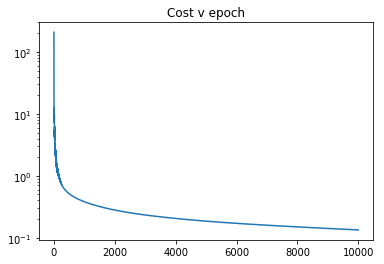

In [4]:
# Train the model
updated_model, costs, accuracy = trainer.train(mgr, X_train, Y_train, 10000, 2500)

f, ax = plt.subplots()
ax.plot(costs)
ax.set_yscale('log')
ax.set_title("Cost v epoch")

mgr.update_model(updated_model)
print("ModelManager updated with trained model. Dev accuracy: {}".format(trainer.correct(mgr.model, X_test, Y_test)))

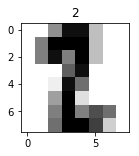

In [6]:
# Vizualize a random example
def visualize(x, title):
    f, ax = plt.subplots(figsize=(2,2))
    ax.imshow(x.reshape(8, 8), cmap=plt.cm.gray_r)
    ax.set_title(title)

def get_random_example(X, Y):
    import random
    idx = random.randrange(0, X.shape[1])
    return X[:, idx].reshape(-1, 1), np.argmax(Y[:, idx])

X_, Y_ = get_random_example(X_train, Y_train)
visualize(X_, str(Y_))

In [7]:
# create our ONNX model
onnx_graph = mgr.make_graph()
onnx_model = mgr.make_model()

# validate it
from onnx import checker
checker.check_model(onnx_model)
checker.check_graph(onnx_graph)

In [8]:
# and run it in another ML system (TensorFlow in this case)
from onnx_tf.backend import prepare
output = prepare(onnx_model).run(X_)  # run the loaded model
output = np.array(output).ravel()[0]

/usr/local/lib/python3.6/site-packages/onnx_tf/common/handler_helper.py:74: UserWarning: Unknown op ConstantLike in domain `ai.onnx`.
  handler.ONNX_OP, handler.DOMAIN or "ai.onnx"))


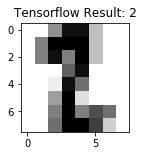

In [11]:
# and visualize the result!
visualize(X_, 'Tensorflow Result: {}'.format(output))

In [15]:
%%timeit
# let's see what it takes for tensorflow's runner to run it
X_, Y_ = get_random_example(X_train, Y_train)
output = prepare(onnx_model).run(X_)  # run the loaded model
output = np.array(output).ravel()[0]

UsageError: Line magic function `%%timeit` not found.


In [ ]:
%%timeit
# let's see what it takes for simpledl to run it directly
X_, Y_ = get_random_example(X_train, Y_train)
output = trainer.predict(mgr.model, X_)